In [2]:
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import click
def _save_datasets(X_train, X_test, y_train, y_test, outdir: Path):
    """Save data sets into nice directory structure and write SUCCESS flag."""
    out_X_train = outdir / 'X_train.csv'
    out_X_test = outdir / 'X_test.csv'
    out_y_train = outdir / 'y_train.csv'
    out_y_test = outdir / 'y_test.csv'
    flag = outdir / '.SUCCESS'
    y_train.columns = ['rating']
    y_test.columns =['rating']
    X_train.to_csv(out_X_train, index=False)
    X_test.to_csv(out_X_test, index=False)
    y_train.to_csv(out_y_train, index=False, header=['rating'])
    y_test.to_csv(out_y_test, index=False, header=['rating'] )
    print('done!')

    flag.touch()




# @click.command()
# @click.option('--in-csv')
# @click.option('--out-dir')
def make_datasets(in_csv, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Connect to the dask cluster
#     c = Client('dask-scheduler:8786')

    # load data as a dask Dataframe if you have trouble with dask
    # please fall back to pandas or numpy
    df = pd.read_csv(in_csv)

    # we set the index so we can properly execute loc below
#     df = df.set_index('Unnamed: 0')

    df = df.drop(['Unnamed: 0', 'description', 'designation', 'taster_twitter_handle', 'title'], axis=1)
    df['country'] = df.country.where(df.country=='', 'US')

    df['price'] = df.price.where(df.price=='', df['price'].mean())
    df['region_1'] = df. region_1.where(df.region_1=='', 'Napa Valley')
    df['region_2'] = df.region_2.where(df.region_2=='', 'Central Coast')
    df['province'] = df.province.where(df.province=='', 'California')
    df['taster_name'] = df.taster_name.where(df.taster_name=='', 'Roger Voss')
    
    df['rating']=0
    
    df.loc[(df['points']<86), 'rating'] = 1
    df.loc[(df['points']>=86) & (df['points']<91), 'rating'] = 2
    df.loc[(df['points']>=91) & (df['points']<96), 'rating'] = 3
    df.loc[(df['points']>=96), 'rating'] = 4

#     cols = list(df.columns)
#     a, b = cols.index('points'), cols.index('winery')
#     cols[b], cols[a] = cols[a], cols[b]
#     df = df[cols]

    X = df[:].drop(['rating'], axis=1)
    X= pd.get_dummies(X)
    y= df['rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    _save_datasets(X_train, X_test, y_train, y_test, Path('new_dir'))
    


if __name__ == '__main__':
    make_datasets('wine_dataset.csv', 'new_dir')


done!


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

from joblib import dump
# @click.command()
# @click.option('--X-train')
# @click.option('--y-train')
# @click.option('--out-dir')
def train_data(X_train,X_test, y_train, y_test, outdir):
    outdir = Path(outdir)
    X_train = pd.read_csv(str(outdir / X_train))
#     X_test = pd.read_csv(str(outdir / X_test))
    y_train = pd.read_csv(str(outdir / y_train))
    
    
#     X_train = pd.get_dummies(X_train)
#     y_test = pd.read_csv(str(outdir / y_test))
    
#     enc = OneHotEncoder(handle_unknown='ignore')
#     X_train = enc.fit_transform(X_train)
#     X_test = enc.fit_transform(X_test.reshape(1, -1))
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    dump(rfc, 'model.joblib')
train_data('X_train.csv','X_test.csv', 'y_train.csv', 'y_test.csv', 'new_dir')

/Users/oluwasogo/mlvenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       492
           2       1.00      1.00      1.00      1736
           3       0.99      1.00      0.99       753
           4       1.00      0.58      0.73        19

   micro avg       1.00      1.00      1.00      3000
   macro avg       1.00      0.89      0.93      3000
weighted avg       1.00      1.00      1.00      3000

---------
[[ 492    0    0    0]
 [   2 1734    0    0]
 [   0    0  753    0]
 [   0    0    8   11]]
----------
0.9966666666666667


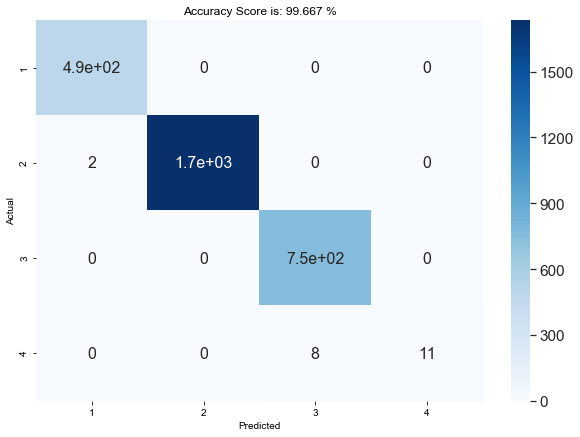

In [5]:
from joblib import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# @click.command()
# @click.option('--X-test')
# @click.option('--y-test')
# @click.option('--pickle')
# @click.option('--out-dir')
X_test = ('X_test.csv')
y_test = ('y_test.csv')
def evaluate_model(X_test, y_test, model, out_dir):
        out_dir = Path(out_dir)
        X_test = pd.read_csv(out_dir / X_test)
        y_test = pd.read_csv(out_dir / y_test)
        model = load(model)
#         X_test = pd.get_dummies(X_test)
        prediction = model.predict(X_test)
        score = accuracy_score(prediction, y_test)
        print(classification_report(y_test, prediction))
        print('---------')
        print(confusion_matrix(y_test, prediction))
        print('----------')
        print(score)
        
        data = confusion_matrix(y_test, prediction)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        
        
        plt.figure(figsize = (10,7))
        plt.title('Accuracy Score is: {} %'.format(round(score*100, 3)))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
        plt.savefig('comfusion_matrix.png')
        
evaluate_model(X_test, y_test,'model.joblib', 'new_dir')